In [162]:
# !pip install catboost
# !pip install shap

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

import shap

In [195]:
df_data_without_target = pd.read_csv('data/vkusvill_data_without_target.csv')
df_target = pd.read_csv('data/vkusvill_target.csv')
df = df_data_without_target.merge(df_target, on='Номерточки', how='inner')
df["Средний чек"] = df["Выручка р/мес"] / df["Чеки шт/мес"]

Преобразование признаков графика работы и города

In [196]:
work_schedule = [
    ['с 9-00 до 22-00', 9, 22, 9, 22, 0], 
    ['с 8-00 до 22-00', 8, 22, 8, 22, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 8-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['Откл. с 9:00 до 22:00', 9, 22, 9, 22, 0], 
    ['с 7-00 до 22-00', 7, 22, 7, 22, 0],
    ['будни с 8-00 до 22-00; вых. с 9-00 до 22-00', 8, 22, 9, 22, 1], 
    ['с 10-00 до 22-00', 10, 22, 10, 22, 0],
    ['будни с 9-00 до 23-00, выходные с 9-00 до 22-00', 9, 23, 9, 22, 1],
    ['с 9-00 до 21-00', 9, 21, 9, 21, 0], 
    ['Будни с 8 до 23, вых с 8 до 22', 8, 23, 8, 22, 1],
    ['с 7:00 до 23:45', 7, 23, 7, 23, 0], 
    ['Откл. с 11:00 до 21:00', 11, 21, 11, 21, 0],
    ['Откл. с 8:00 до 22:00', 8, 22, 8, 22, 0], 
    ['с 8-00 до 23-45', 8, 23, 8, 23, 0], 
    ['с 8-00 до 23-00', 8, 23, 8, 23, 0],
    ['Будни с8:00 до 23:00 вых с 8:00 до 22:00', 8, 23, 8, 22, 1],
    ['будни с 8-00 до 23-00, вых. 9-00 до 23-00', 8, 23, 9, 23, 1],
    ['пн-пт с 8-00 до 23-00, сб-вс с 9-00 до 22-00', 8, 23, 9, 22, 1],
    ['вс-чт. с 10:00 до 23:00, пт-сб. с 10:00 по 24:00', 10, 23, 10, 24, 1],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['с 8-30 до 23-00', 8, 23, 8, 23, 0], 
    ['с 7-00 до 23-45', 7, 23, 7, 23, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 22-00, вс с 8-00 - 23-45', 7, 23, 8, 23, 1],
    ['с пн по чт с 7 до 23:45, пт с 7 до 23:00, сб с 8 до 22:00, вс 8 до 23:45', 7, 23, 8, 23, 1],
    ['бд 7-00 до23-00 вх 8-00 до 22-00', 7, 23, 8, 22, 1], 
    ['с 9:00 до 23:00', 9, 23, 9, 23, 0],
    ['с 7-00 до 23-00', 7, 23, 7, 23, 0]
]

work_schedule = pd.DataFrame(
    work_schedule, 
    columns=["График", "Будни начало", "Будни конец", "Выходные начало", "Выходные конец", "Разные графики"]
    )

df = pd.merge(df, work_schedule, on="График", how="left")
df['Рабочие часы в будни'] = df['Будни конец'] - df['Будни начало']
df['Рабочие часы в выходные'] = df['Выходные конец'] - df['Выходные начало']
df['Ночной магазин'].replace({'Нет': 0, 'Да': 1}, inplace=True)

df = pd.concat([df, pd.get_dummies(df['Город'])], axis=1)

# df.set_index('Номерточки',inplace=True)

df = df[['Дата открытия', 'Торговая площадь, м2',
       'Ночной магазин', 'Выручка р/мес', 'Чеки шт/мес', 'Средний чек',
       'Будни начало', 'Будни конец', 'Выходные начало', 'Выходные конец',
       'Разные графики', 'Рабочие часы в будни', 'Рабочие часы в выходные',
       'Волоколамск', 'Дедовск', 'Дмитров', 'Долгопрудный', 'Дубна',
       'Зеленоград', 'Ивантеевка', 'Истра', 'Клин', 'Королев', 'Красногорск',
       'Лобня', 'Москва', 'Мытищи', 'Нахабино', 'Некрасовский', 'Новинки',
       'Павловская Слобода', 'Путилково', 'Пушкино', 'Сабурово',
       'Сергиев Посад', 'Солнечногорск', 'Солнечногорский р-он, д. Подолино',
       'Химки', 'Хотьково', 'Юбилейный', 'Яхрома']]

Нормировка данных

In [197]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(df[['Дата открытия', 'Торговая площадь, м2', 'Будни начало',
       'Будни конец', 'Выходные начало', 'Выходные конец', 'Разные графики',
       'Рабочие часы в будни', 'Рабочие часы в выходные']])

scaled_df = pd.DataFrame(d, columns=['Дата открытия', 'Торговая площадь, м2', 'Будни начало',
       'Будни конец', 'Выходные начало', 'Выходные конец', 'Разные графики',
       'Рабочие часы в будни', 'Рабочие часы в выходные'])

df = df.drop(columns = ['Дата открытия', 'Торговая площадь, м2', 'Будни начало',
       'Будни конец', 'Выходные начало', 'Выходные конец', 'Разные графики',
       'Рабочие часы в будни', 'Рабочие часы в выходные'], axis = 1)

df = pd.concat([df, scaled_df], axis=1)

In [198]:
df.head(3)

,Ночной магазин,Выручка р/мес,Чеки шт/мес,Средний чек,Волоколамск,Дедовск,Дмитров,Долгопрудный,Дубна,Зеленоград,...,Яхрома,Дата открытия,"Торговая площадь, м2",Будни начало,Будни конец,Выходные начало,Выходные конец,Разные графики,Рабочие часы в будни,Рабочие часы в выходные
0,0,39098.035556,204.773333,190.933238,0,0,0,0,0,0,...,0,0.893067,0.061312,0.50,0.5,0.50,0.333333,0.0,0.500000,0.500000
1,0,30782.080000,117.173333,262.705508,0,0,0,0,0,0,...,0,0.689777,0.091492,0.50,0.5,0.50,0.333333,0.0,0.500000,0.500000
2,0,28921.148889,201.533333,143.505535,0,0,0,0,0,0,...,0,0.337544,0.085551,0.25,0.5,0.25,0.333333,0.0,0.666667,0.666667


In [199]:
all_data_test_revenue = df['Выручка р/мес']
all_data_test_avg_check = df['Средний чек']
all_data_train = df.drop(columns = ['Выручка р/мес', 'Чеки шт/мес', 'Средний чек'],axis = 1)

In [200]:
results_revenue = []
results_avg_check = []

In [201]:
# CatBoostRegressor

X_train, y_train = all_data_train, all_data_test_revenue.to_numpy()
CatBoostReg = CatBoostRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(CatBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('CatBoostRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue.append(('CatBoostRegressor', scores.mean()))

X_train, y_train = all_data_train, all_data_test_avg_check.to_numpy()
CatBoostReg = CatBoostRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(CatBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('CatBoostRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check.append(('CatBoostRegressor', scores.mean()))

CatBoostRegressor revenue mean MAPE: 0.196
CatBoostRegressor avg_check mean MAPE: 0.132


In [202]:
# RandomForestRegressor

X_train, y_train = all_data_train, all_data_test_revenue.to_numpy()
forest = RandomForestRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('RandomForestRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue.append(('RandomForestRegressor', scores.mean()))

X_train, y_train = all_data_train, all_data_test_avg_check.to_numpy()
forest = RandomForestRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('RandomForestRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check.append(('RandomForestRegressor', scores.mean()))

RandomForestRegressor revenue mean MAPE: 0.190
RandomForestRegressor avg_check mean MAPE: 0.128


In [203]:
# AdaBoostRegressor

X_train, y_train = all_data_train, all_data_test_revenue.to_numpy()
AdaBoostReg = AdaBoostRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(AdaBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('AdaBoostRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue.append(('AdaBoostRegressor', scores.mean()))

X_train, y_train = all_data_train, all_data_test_avg_check.to_numpy()
AdaBoostReg = AdaBoostRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(AdaBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('AdaBoostRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check.append(('AdaBoostRegressor', scores.mean()))

AdaBoostRegressor revenue mean MAPE: 0.218
AdaBoostRegressor avg_check mean MAPE: 0.135


In [204]:
# GradientBoostingRegressor

X_train, y_train = all_data_train, all_data_test_revenue.to_numpy()
GBReg = GradientBoostingRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(GBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('GradientBoostingRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue.append(('GradientBoostingRegressor', scores.mean()))

X_train, y_train = all_data_train, all_data_test_avg_check.to_numpy()
GBReg = GradientBoostingRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(GBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('GradientBoostingRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check.append(('GradientBoostingRegressor', scores.mean()))

GradientBoostingRegressor revenue mean MAPE: 0.190
GradientBoostingRegressor avg_check mean MAPE: 0.130


In [205]:
# XGBRegressor

X_train, y_train = all_data_train, all_data_test_revenue.to_numpy()
XGBReg = XGBRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(XGBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('XGBRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue.append(('XGBRegressor', scores.mean()))

X_train, y_train = all_data_train, all_data_test_avg_check.to_numpy()
XGBReg = XGBRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(XGBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('XGBRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check.append(('XGBRegressor', scores.mean()))

XGBRegressor revenue mean MAPE: 0.215
XGBRegressor avg_check mean MAPE: 0.142


In [206]:
results_revenue = sorted(results_revenue,key = lambda x: x[1])
results_avg_check = sorted(results_avg_check,key = lambda x: x[1])

df_results_revenue = pd.DataFrame(results_revenue, columns=['model', 'result'])
df_results_avg_check = pd.DataFrame(results_avg_check, columns=['model', 'result'])

In [207]:
df_results_revenue

,model,result
0,RandomForestRegressor,0.189706
1,GradientBoostingRegressor,0.189784
2,CatBoostRegressor,0.195739
3,XGBRegressor,0.214639
4,AdaBoostRegressor,0.218069


In [208]:
df_results_avg_check

,model,result
0,RandomForestRegressor,0.127951
1,GradientBoostingRegressor,0.130011
2,CatBoostRegressor,0.131707
3,AdaBoostRegressor,0.134866
4,XGBRegressor,0.142303


## Добавляем дополнительные признаки из OSM

In [209]:
new_features = pd.read_csv('data/vkusvill_new_features.csv')
new_features = new_features[['fuel', 'bus_stop', 'house', 'kiosk', 'retail',
       'station', 'subway_entrance', 'tram_stop', 'bar', 'cafe', 'fast_food',
       'food_court', 'pub', 'restaurant', 'college', 'driving_school',
       'language_school', 'school', 'kindergarten', 'university', 'car_wash',
       'atm', 'bank', 'clinic', 'dentist', 'doctors', 'hospital', 'pharmacy',
       'veterinary', 'theatre', 'cinema', 'hostel', 'hotel', 'office', 'shop']]

In [210]:
d = scaler.fit_transform(new_features)
scaled_df = pd.DataFrame(d, columns = new_features.columns)
all_data_train_new_features = pd.concat([all_data_train, scaled_df], axis=1)

In [211]:
all_data_train_new_features.head(3)

,Ночной магазин,Волоколамск,Дедовск,Дмитров,Долгопрудный,Дубна,Зеленоград,Ивантеевка,Истра,Клин,...,doctors,hospital,pharmacy,veterinary,theatre,cinema,hostel,hotel,office,shop
0,0,0,0,0,0,0,0,0,0,0,...,0.066667,0.000000,0.092593,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.112676
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.005319,0.007682
2,0,0,0,0,0,0,0,0,0,0,...,0.400000,0.666667,0.462963,0.75,0.08,0.0,0.142857,0.118644,0.244681,0.495519


In [212]:
results_revenue_with_new_features = []
results_avg_check_with_new_features = []

In [213]:
# CatBoostRegressor

X_train, y_train = all_data_train_new_features, all_data_test_revenue.to_numpy()
CatBoostReg = CatBoostRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(CatBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('CatBoostRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue_with_new_features.append(('CatBoostRegressor', scores.mean()))

X_train, y_train = all_data_train_new_features, all_data_test_avg_check.to_numpy()
CatBoostReg = CatBoostRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(CatBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('CatBoostRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check_with_new_features.append(('CatBoostRegressor', scores.mean()))


# RandomForestRegressor

X_train, y_train = all_data_train_new_features, all_data_test_revenue.to_numpy()
forest = RandomForestRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('RandomForestRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue_with_new_features.append(('RandomForestRegressor', scores.mean()))

X_train, y_train = all_data_train_new_features, all_data_test_avg_check.to_numpy()
forest = RandomForestRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('RandomForestRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check_with_new_features.append(('RandomForestRegressor', scores.mean()))


# AdaBoostRegressor

X_train, y_train = all_data_train_new_features, all_data_test_revenue.to_numpy()
AdaBoostReg = AdaBoostRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(AdaBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('AdaBoostRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue_with_new_features.append(('AdaBoostRegressor', scores.mean()))

X_train, y_train = all_data_train_new_features, all_data_test_avg_check.to_numpy()
AdaBoostReg = AdaBoostRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(AdaBoostReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('AdaBoostRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check_with_new_features.append(('AdaBoostRegressor', scores.mean()))


# GradientBoostingRegressor

X_train, y_train = all_data_train_new_features, all_data_test_revenue.to_numpy()
GBReg = GradientBoostingRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(GBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('GradientBoostingRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue_with_new_features.append(('GradientBoostingRegressor', scores.mean()))

X_train, y_train = all_data_train_new_features, all_data_test_avg_check.to_numpy()
GBReg = GradientBoostingRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(GBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('GradientBoostingRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check_with_new_features.append(('GradientBoostingRegressor', scores.mean()))


# XGBRegressor

X_train, y_train = all_data_train_new_features, all_data_test_revenue.to_numpy()
XGBReg = XGBRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(XGBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('XGBRegressor revenue mean MAPE: %.3f' % scores.mean())
results_revenue_with_new_features.append(('XGBRegressor', scores.mean()))

X_train, y_train = all_data_train_new_features, all_data_test_avg_check.to_numpy()
XGBReg = XGBRegressor(n_estimators=100,random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(XGBReg, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('XGBRegressor avg_check mean MAPE: %.3f' % scores.mean())
results_avg_check_with_new_features.append(('XGBRegressor', scores.mean()))

CatBoostRegressor revenue mean MAPE: 0.191
CatBoostRegressor avg_check mean MAPE: 0.121
RandomForestRegressor revenue mean MAPE: 0.191
RandomForestRegressor avg_check mean MAPE: 0.118
AdaBoostRegressor revenue mean MAPE: 0.207
AdaBoostRegressor avg_check mean MAPE: 0.123
GradientBoostingRegressor revenue mean MAPE: 0.199
GradientBoostingRegressor avg_check mean MAPE: 0.122
XGBRegressor revenue mean MAPE: 0.199
XGBRegressor avg_check mean MAPE: 0.126


In [214]:
results_revenue_with_new_features = sorted(results_revenue_with_new_features,key = lambda x: x[1])
results_avg_check_with_new_features = sorted(results_avg_check_with_new_features,key = lambda x: x[1])

df_results_revenue_with_new_features = pd.DataFrame(results_revenue_with_new_features, columns=['model', 'result'])
df_results_avg_check_with_new_features = pd.DataFrame(results_avg_check_with_new_features, columns=['model', 'result'])

In [215]:
df_results_revenue

,model,result
0,RandomForestRegressor,0.189706
1,GradientBoostingRegressor,0.189784
2,CatBoostRegressor,0.195739
3,XGBRegressor,0.214639
4,AdaBoostRegressor,0.218069


In [216]:
df_results_revenue_with_new_features

,model,result
0,CatBoostRegressor,0.191137
1,RandomForestRegressor,0.191149
2,GradientBoostingRegressor,0.198609
3,XGBRegressor,0.199395
4,AdaBoostRegressor,0.207151


In [217]:
df_results_avg_check

,model,result
0,RandomForestRegressor,0.127951
1,GradientBoostingRegressor,0.130011
2,CatBoostRegressor,0.131707
3,AdaBoostRegressor,0.134866
4,XGBRegressor,0.142303


In [218]:
df_results_avg_check_with_new_features

,model,result
0,RandomForestRegressor,0.117919
1,CatBoostRegressor,0.120507
2,GradientBoostingRegressor,0.121742
3,AdaBoostRegressor,0.123079
4,XGBRegressor,0.125991


Визуализация важности признаков для модели предсказания количества чеков

In [220]:
X_train, y_train = all_data_train[:260], all_data_test_avg_check[:260]
X_test, y_test = all_data_train[260:], all_data_test_avg_check[260:]

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred_test = forest.predict(X_test)
print('RandomForestRegressor revenue MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))

explainer = shap.Explainer(forest.predict, X_test)
shap_values = explainer(X_test)

RandomForestRegressor revenue MAPE: 0.114


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


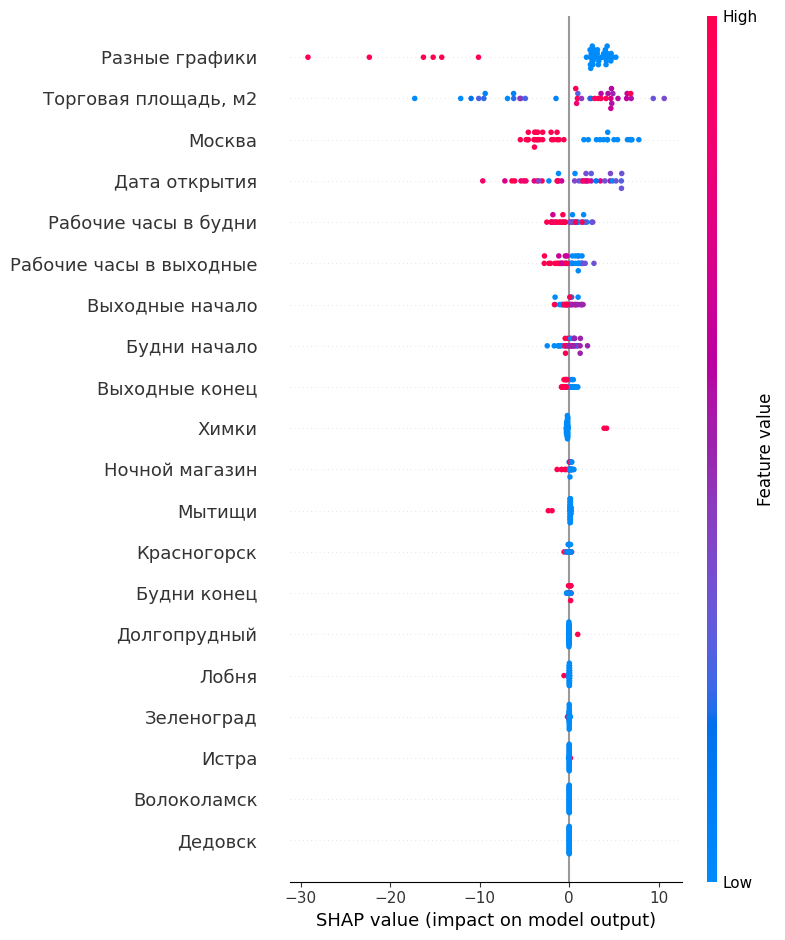

In [222]:
shap.summary_plot(shap_values)

Визуализация важности признаков для модели предсказания выручки

In [223]:
X_train, y_train = all_data_train[:260], all_data_test_revenue[:260]
X_test, y_test = all_data_train[260:], all_data_test_revenue[260:]

GBReg = GradientBoostingRegressor()
GBReg.fit(X_train, y_train)
y_pred_test = GBReg.predict(X_test)
print('GradientBoostingRegressor revenue MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))

explainer = shap.Explainer(GBReg.predict, X_test)
shap_values = explainer(X_test)

GradientBoostingRegressor revenue MAPE: 0.222


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


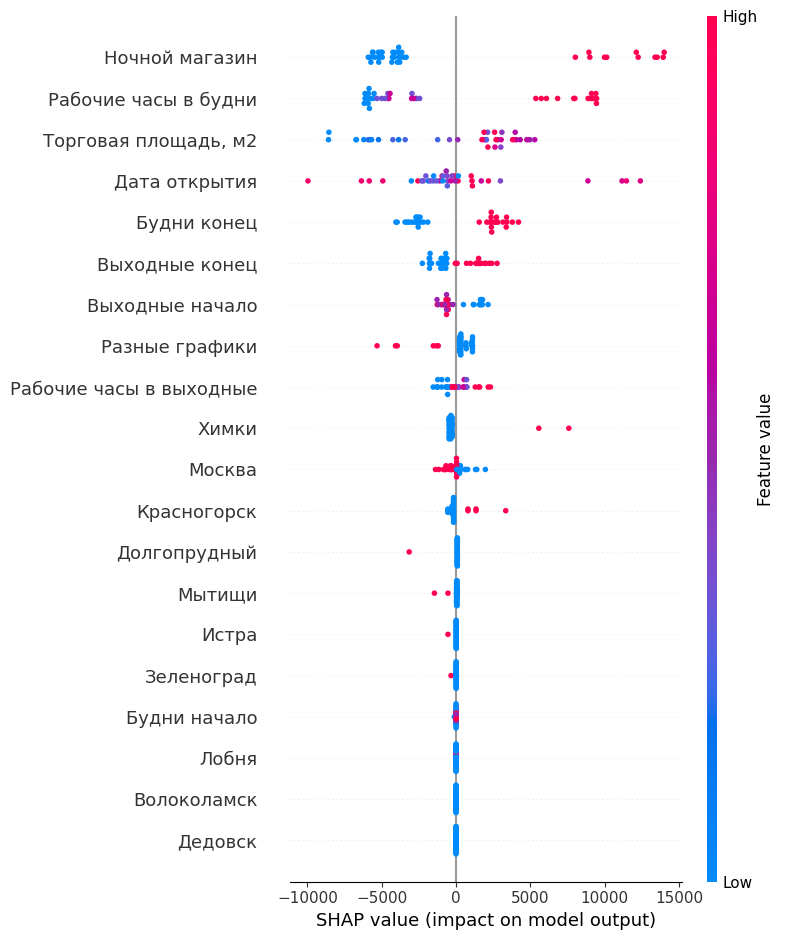

In [225]:
shap.summary_plot(shap_values)